In [ ]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import xclimate as xclim

In [2]:
ilamb_varname = "hfls"
indir = Path("/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed")

# Zonal mean
ilamb_zm = xr.open_dataset(indir / f"zonal_mean/{ilamb_varname.upper()}_ZONAL_MEAN_ILAMB_2003-2009.nc")["et_itzavg_overlap"]

# Global mean
ilamb_gm = {}
for f in indir.glob("global_mean/*.nc"):
    key = f.stem.split("_")[3]
    ilamb_gm[key] = xr.open_dataset(f)[ilamb_varname.lower()+"_"+key]

In [3]:
varname = "EFLX_LH_TOT"

# Load parameter settings key
clm6_key = pd.read_csv("/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/ctsm6_oaat_key.csv")

# Load postprocessed temporally averaged dataset 
in_file = Path("/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_1985-2023.nc")
clm6_tm = xr.open_dataset(in_file)

# Append key to ds
clm6_tm = clm6_tm.assign_coords(
    key=("member", clm6_key["key"].values),
    param=("member", clm6_key["param"].values),
    minmax=("member", clm6_key["minmax"].values)
)
clm6_tm = clm6_tm.set_index(ens=["param", "minmax", "key"], append=True)
clm6_tm = clm6_tm[[v for v in clm6_tm.data_vars if str(v).startswith(varname)]]


# Load postprocessed timeseries dataset
in_file = Path("/glade/campaign/cgd/tss/projects/PPE/ctsm6_oaat/postp/ctsm6_oaat_postp_timeseries_1901-2023.nc")
clm6_ts = xr.open_dataset(in_file)

# Append key to ds
clm6_ts = clm6_ts.assign_coords(
    key=("member", clm6_key["key"].values),
    param=("member", clm6_key["param"].values),
    minmax=("member", clm6_key["minmax"].values)
)
clm6_ts = clm6_ts.set_index(ens=["param", "minmax", "key"], append=True)
clm6_ts = clm6_ts[[v for v in clm6_ts.data_vars if str(v).startswith(varname)]]

In [4]:
grid_fhist = xclim.load_coupled_fhist_ppe("EFLX_LH_TOT", "lnd", "month_1")[["area", "landfrac"]].isel(member=0).fillna(0)
la_fhist = grid_fhist.area * grid_fhist.landfrac
et_fhist = xclim.load_coupled_fhist_ppe("EFLX_LH_TOT", "lnd", "month_1", keep_var_only=True)["EFLX_LH_TOT"]

In [ ]:
grid_le = xclim.load_cesm2le("EFLX_LH_TOT", "lnd", "month_1", "h0")[["area", "landfrac"]].isel(member=0, time=0).fillna(0)
la_le = grid_le.area * grid_le.landfrac

et_le = xclim.load_cesm2le("EFLX_LH_TOT", "lnd", "month_1", "h0", keep_var_only=True).sel(time=slice("1900-01", None))["EFLX_LH_TOT"]

lh_le = xclim.load_cesm2le("LHFLX", "atm", "month_1", "h0", keep_var_only=True, chunk=True).sel(time=slice("1900-01", None))["LHFLX"]
lh_le = lh_le.reindex(lat=la_le.lat, lon=la_le.lon, method="nearest", tolerance=1e-3)

In [ ]:
lh_le.isel(member=0, time=slice(-10*12, None)).weighted(la_le).mean(dim=["lat", "lon"]).groupby("time.year").mean().plot()
et_le.isel(member=0, time=slice(-10*12, None)).weighted(la_le).mean(dim=["lat", "lon"]).groupby("time.year").mean().plot()

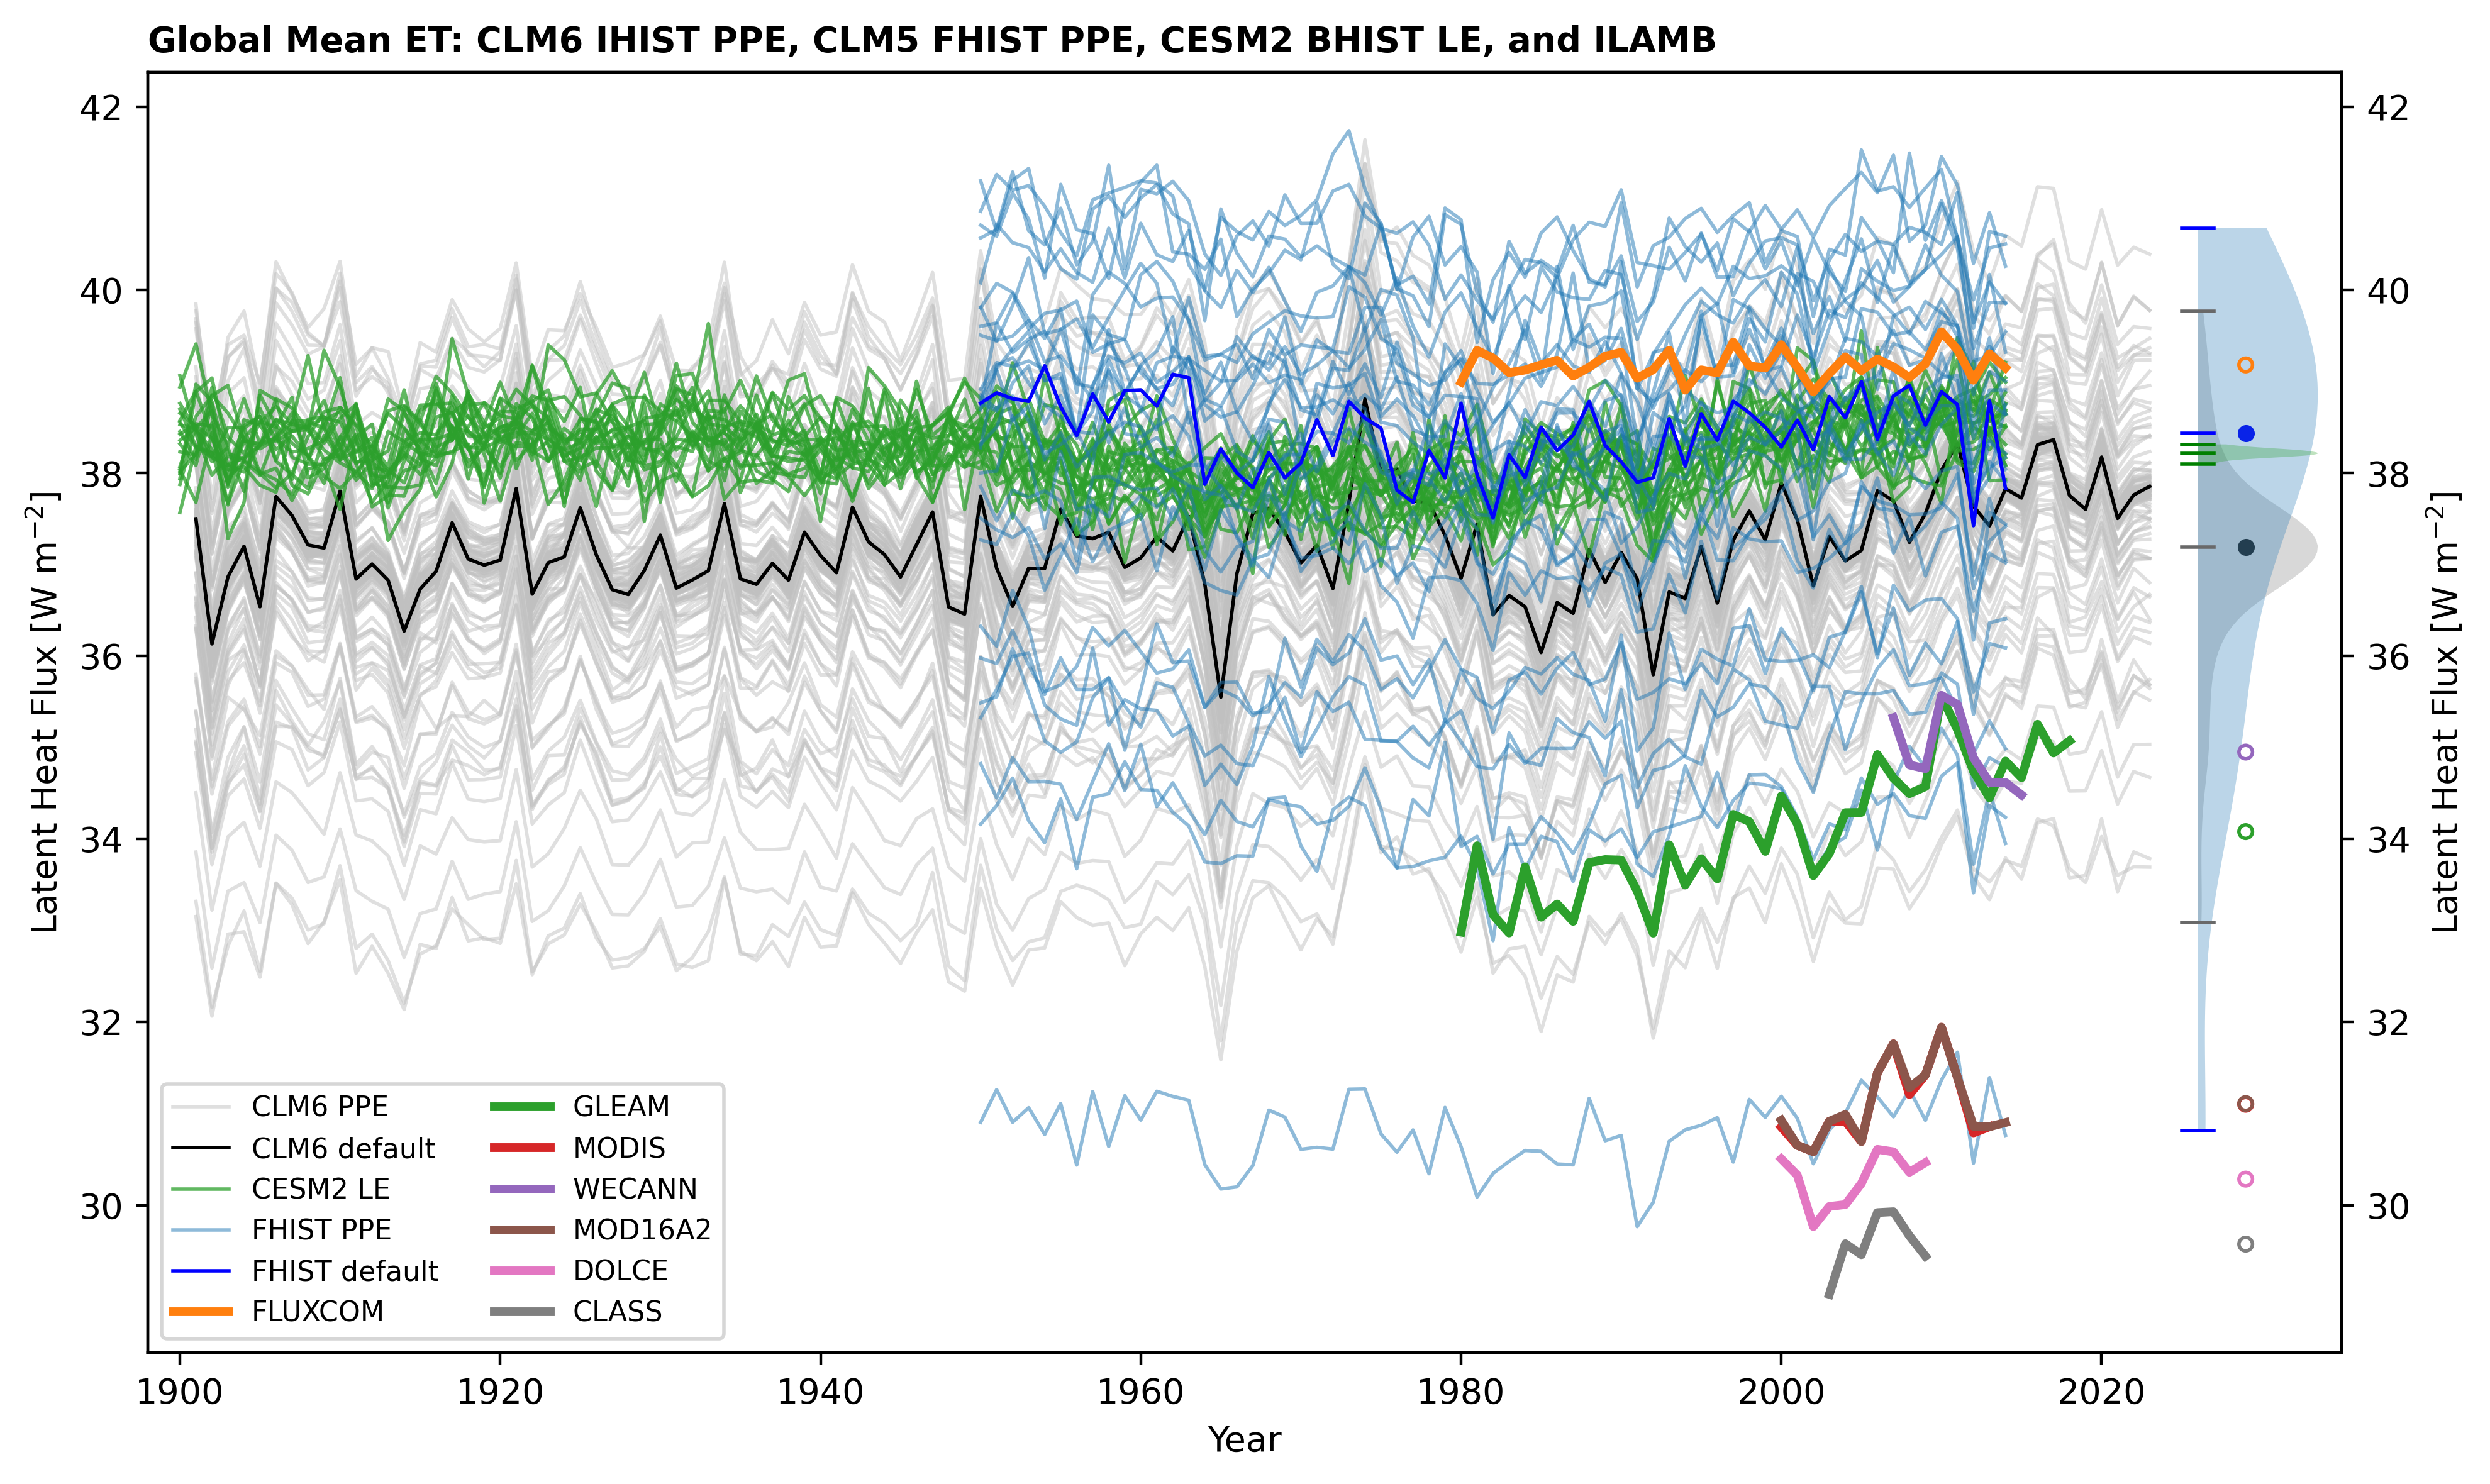

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=400)

cs_clm6 = []
vp_xpos = 2026
cs_ilamb = list(mpl.colors.TABLEAU_COLORS.keys())[1:]


# Plot all the CLM6 PPE ensemble members
for i, e in enumerate(clm6_ts.ens):
    label = None
    if i == 0:
        label = "CLM6 PPE"
    clm6_ts["EFLX_LH_TOT_global_mean"].sel(ens=e).plot(ax=ax, color="silver", alpha=0.5, lw=1, label=label, _labels=False)

# Highlight the CLM6 default
clm6_ts["EFLX_LH_TOT_global_mean"].sel(param="default", minmax="max").plot(ax=ax, color="k", lw=1, ls="-", label="CLM6 default", _labels=False)
ax.scatter(
    vp_xpos+3,
    clm6_ts["EFLX_LH_TOT_global_mean"].sel(param="default", minmax="max").mean(dim="year"),
    s=15,
    marker="o",
    color="k",
)


# Plot all the CESM2 LE ensemble members
for i, e in enumerate(et_le.member):
    label = None
    if i == 0:
        label = "CESM2 LE"
    # et_le.sel(member=e).weighted(la_le).mean(dim=["lat", "lon"]).groupby("time.year").mean().plot(ax=ax, color="tab:green", ls="-", alpha=0.75, lw=1, label=label, _labels=False)
    lh_le.sel(member=e).weighted(la_le).mean(dim=["lat", "lon"]).groupby("time.year").mean().plot(ax=ax, color="tab:green", ls="-", alpha=0.75, lw=1, label=label, _labels=False)


# Plot all the FHIST PPE ensemble members
for i, e in enumerate(et_fhist.member):
    label = None
    if i == 0:
        label = "FHIST PPE"
    et_fhist.sel(member=e).weighted(la_fhist).mean(dim=["lat", "lon"]).groupby("time.year").mean().plot(ax=ax, color="tab:blue", alpha=0.5, lw=1, label=label, _labels=False)

# Highlight the FHIST PPE default
et_fhist.sel(member=0).weighted(la_fhist).mean(dim=["lat", "lon"]).groupby("time.year").mean().plot(ax=ax, color="blue", lw=1, ls="-", label="FHIST default", _labels=False)
ax.scatter(
    vp_xpos+3,
    et_fhist.sel(member=0).weighted(la_fhist).mean(dim=["lat", "lon"]).groupby("time.year").mean().mean(dim="year"),
    s=15,
    marker="o",
    color="blue",
)


# Add a violin plot for the time average of the CLM6 PPE ensemble
vp = ax.violinplot(
    clm6_ts["EFLX_LH_TOT_global_mean"].mean(dim="year"),
    [vp_xpos],
    vert=True,
    widths=15,
    side="high",
    showmeans=False,
    showextrema=True,
    showmedians=True,
)
vp["bodies"][0].set(facecolor="gray")
vp["cbars"].set(linewidth=0)
vp["cmedians"].set(linewidth=1, color="dimgray")
vp["cmins"].set(linewidth=1, color="dimgray")
vp["cmaxes"].set(linewidth=1, color="dimgray")

segmed = vp["cmedians"].get_segments().copy()
segmin = vp["cmins"].get_segments().copy()
segmax = vp["cmaxes"].get_segments().copy()
for smed, smin, smax in zip(segmed, segmin, segmax):
    for s in [smed, smin, smax]:
        s[0][0] = vp_xpos - 1
        s[1][0] = vp_xpos + 1
vp["cmedians"].set_segments(segmed)
vp["cmins"].set_segments(segmin)
vp["cmaxes"].set_segments(segmax)


# Add a violin plot for the time average of the FHIST PPE ensemble
vp = ax.violinplot(
    et_fhist.weighted(la_fhist).mean(dim=["lat", "lon"]).groupby("time.year").mean().mean(dim="year"),
    [vp_xpos],
    vert=True,
    widths=15,
    side="high",
    showmeans=False,
    showextrema=True,
    showmedians=True,
)
vp["bodies"][0].set(facecolor="tab:blue", alpha=0.3)
vp["cbars"].set(linewidth=0)
vp["cmedians"].set(linewidth=1, color="blue")
vp["cmins"].set(linewidth=1, color="blue")
vp["cmaxes"].set(linewidth=1, color="blue")

segmed = vp["cmedians"].get_segments().copy()
segmin = vp["cmins"].get_segments().copy()
segmax = vp["cmaxes"].get_segments().copy()
for smed, smin, smax in zip(segmed, segmin, segmax):
    for s in [smed, smin, smax]:
        s[0][0] = vp_xpos - 1
        s[1][0] = vp_xpos + 1
vp["cmedians"].set_segments(segmed)
vp["cmins"].set_segments(segmin)
vp["cmaxes"].set_segments(segmax)


# Add a violin plot for the time average of the CESM2 LE
vp = ax.violinplot(
    # et_le.weighted(la_le).mean(dim=["lat", "lon"]).groupby("time.year").mean().mean(dim="year"),
    lh_le.weighted(la_le).mean(dim=["lat", "lon"]).groupby("time.year").mean().mean(dim="year"),
    [vp_xpos],
    vert=True,
    widths=15,
    side="high",
    showmeans=False,
    showextrema=True,
    showmedians=True,
)
vp["bodies"][0].set(facecolor="tab:green", alpha=0.3)
vp["cbars"].set(linewidth=0)
vp["cmedians"].set(linewidth=1, color="green")
vp["cmins"].set(linewidth=1, color="green")
vp["cmaxes"].set(linewidth=1, color="green")

segmed = vp["cmedians"].get_segments().copy()
segmin = vp["cmins"].get_segments().copy()
segmax = vp["cmaxes"].get_segments().copy()
for smed, smin, smax in zip(segmed, segmin, segmax):
    for s in [smed, smin, smax]:
        s[0][0] = vp_xpos - 1
        s[1][0] = vp_xpos + 1
vp["cmedians"].set_segments(segmed)
vp["cmins"].set_segments(segmin)
vp["cmaxes"].set_segments(segmax)


# Plot the ILAMB datasets
for i, (key, da) in enumerate(ilamb_gm.items()):
    label_ilamb = key
    ls_ilamb = "-"
    lw_ilamb = 2.5
    ax.plot(da.year, da, c=cs_ilamb[i], ls=ls_ilamb, lw=lw_ilamb, label=label_ilamb, zorder=100)
    ax.scatter(vp_xpos+3, da.mean(dim="year"), marker="o", s=15, edgecolor=cs_ilamb[i], facecolor="none")


ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_ylabel("Latent Heat Flux [W m$^{-2}$]", labelpad=24)

ax.yaxis.set_ticks_position("both")
ax.tick_params(axis="y", labelright=True)
ax.set_ylabel("Latent Heat Flux [W m$^{-2}$]")

ax.legend(loc="lower left", ncol=2, fontsize=8)
ax.set_title("Global Mean ET: CLM6 IHIST PPE, CLM5 FHIST PPE, CESM2 BHIST LE, and ILAMB", loc="left", fontsize=10, fontweight="bold")
ax.set_xlabel("Year")
ax.set_xlim(1898, 2035)

plt.tight_layout()
fig.savefig("./fig/global_et_timeseries_fhist_clm6_cesm2le_ilamb.png", dpi=300)

In [5]:
x = et.weighted(area_clm).mean(dim=["lat", "lon"]).groupby("time.year").mean().mean(dim="year")
x = x.sortby(x).load()

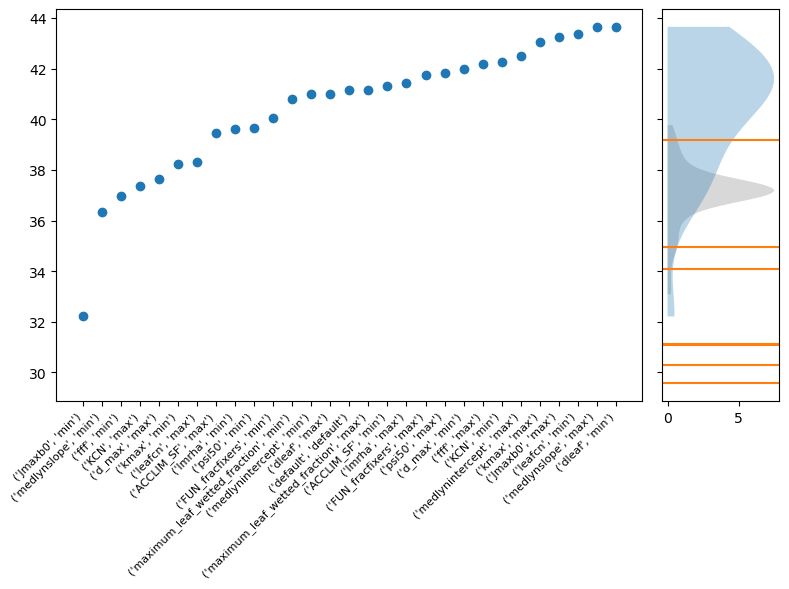

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), width_ratios=[1, 0.2], sharey=True, layout="tight")

ax[0].scatter(np.arange(len(et.member)), x)

for i, (key, da) in enumerate(ilamb_gm.items()):
    ax[1].axhline(da.mean(dim="year"), c="tab:orange")

ax[0].set_xticks(np.arange(len(et.member)))
ax[0].set_xticklabels(utils.get_member_name(x.member), rotation=45, fontsize=8, ha="right");

# ax[1].hist(
#     x, bins=np.arange(30, 46, 1), orientation="horizontal",
#     color="tab:blue", alpha=0.5, density=True)
# ax[1].hist(
#     clm6_ts["EFLX_LH_TOT_global_mean"].mean(dim="year"),
#     bins=np.arange(30, 46, 1), orientation="horizontal",
#     color="dimgray", alpha=0.5, density=True)

vp_xpos = 0

# Add a violin plot for the time average of the CLM6 PPE ensemble
vp = ax[1].violinplot(
    clm6_ts["EFLX_LH_TOT_global_mean"].mean(dim="year"),
    [vp_xpos],
    vert=True,
    widths=15,
    side="high",
    showmeans=False,
    showextrema=True,
    showmedians=True,
)
vp["bodies"][0].set(facecolor="gray")
vp["cbars"].set(linewidth=0)
vp["cmedians"].set(linewidth=0, color="dimgray")
vp["cmins"].set(linewidth=0, color="dimgray")
vp["cmaxes"].set(linewidth=0, color="dimgray")

segmed = vp["cmedians"].get_segments().copy()
segmin = vp["cmins"].get_segments().copy()
segmax = vp["cmaxes"].get_segments().copy()
for smed, smin, smax in zip(segmed, segmin, segmax):
    for s in [smed, smin, smax]:
        s[0][0] = vp_xpos - 1
        s[1][0] = vp_xpos + 1
vp["cmedians"].set_segments(segmed)
vp["cmins"].set_segments(segmin)
vp["cmaxes"].set_segments(segmax)


# Add a violin plot for the time average of the FHIST PPE ensemble
vp = ax[1].violinplot(
    x,
    [vp_xpos],
    vert=True,
    widths=15,
    side="high",
    showmeans=False,
    showextrema=True,
    showmedians=True,
)
vp["bodies"][0].set(facecolor="tab:blue", alpha=0.3)
vp["cbars"].set(linewidth=0)
vp["cmedians"].set(linewidth=0, color="blue")
vp["cmins"].set(linewidth=0, color="blue")
vp["cmaxes"].set(linewidth=0, color="blue")

segmed = vp["cmedians"].get_segments().copy()
segmin = vp["cmins"].get_segments().copy()
segmax = vp["cmaxes"].get_segments().copy()
for smed, smin, smax in zip(segmed, segmin, segmax):
    for s in [smed, smin, smax]:
        s[0][0] = vp_xpos - 1
        s[1][0] = vp_xpos + 1
vp["cmedians"].set_segments(segmed)
vp["cmins"].set_segments(segmin)
vp["cmaxes"].set_segments(segmax)